In [22]:
from sqlalchemy import create_engine
import pandas as pd
import pyodbc
from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [14]:
# This CSV is outputted from R before normailization
# Model_Data = pd.read_csv("Model_Norm.csv", )
# Model_Data

In [23]:
########### CONNECT TO ThalesStockPredictor SQLServer DB

# Define connection string
connStr = 'mssql+pyodbc://@MSI/ThalesStockPredictor?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server'

# Create SQLAlchemy engine
engine = create_engine(connStr)

# Define the query
query = """
SELECT * FROM vw_COMBINED_MODEL
ORDER BY FK_DT_Date desc
"""

# Execute the query and assign the result to a pandas DataFrame
Model_Data = pd.read_sql(query, engine)

# Close the SQL Server Connection
engine.dispose()

In [24]:
# View the data
Model_Data

,FK_DT_Date,THA_Open,THA_High,THA_Low,THA_Close,THA_Adj_Close,THA_Volume,THA_NextDay_Close,SPI_Open,SPI_High,...,SPI_SMA,SPI_UpperBand,SPI_LowerBand,FRA_SMA,FRA_UpperBand,FRA_LowerBand,THA_OBV,EUR_OBV,SPI_OBV,FRA_OBV
0,2024-03-05,145.000000,151.050003,143.350006,150.899994,150.899994,669756.0,NaN,5110.520020,5114.540039,...,5038.216455,5149.478140,4926.954770,7813.302490,8071.131062,7555.473919,2.318764e+10,2.318764e+10,1.295084e+12,8.148700e+09
1,2024-03-04,136.000000,138.600006,135.850006,138.350006,138.350006,351633.0,150.899994,5130.990234,5149.669922,...,5032.122949,5150.409361,4913.836537,7798.610010,8061.207936,7536.012083,2.318764e+10,2.318764e+10,1.296771e+12,8.148700e+09
2,2024-03-01,137.500000,138.250000,135.399994,135.399994,135.399994,236008.0,138.350006,5098.509766,5140.330078,...,5023.505933,5136.468663,4910.543202,7780.287500,8047.620766,7512.954234,2.318886e+10,2.318886e+10,1.301530e+12,8.104148e+09
3,2024-02-29,137.250000,137.300003,135.699997,137.050003,137.050003,984695.0,135.399994,5085.359863,5104.990234,...,5011.961426,5123.232730,4900.690122,7763.191992,8032.810869,7493.573116,2.310308e+10,2.310308e+10,1.296782e+12,8.053039e+09
4,2024-02-28,137.000000,137.149994,135.850006,136.600006,136.600006,186668.0,137.050003,5067.200195,5077.370117,...,4999.430420,5126.106344,4872.754496,7746.257983,8014.985481,7477.530486,2.300034e+10,2.300034e+10,1.291562e+12,8.161566e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,2000-01-07,33.500000,35.119999,33.349998,35.049999,19.815237,506662.0,35.200001,1403.449951,1441.469971,...,1420.333984,1472.471683,1368.196286,5611.762012,5993.606240,5229.917784,-8.448290e+07,-8.448290e+07,2.394000e+09,0.000000e+00
6212,2000-01-06,33.000000,33.400002,32.599998,33.160000,18.746742,178098.0,35.049999,1402.109985,1411.900024,...,1415.049988,1468.714715,1361.385261,5629.800049,6060.764238,5198.835860,-1.405418e+08,-1.405418e+08,1.168800e+09,0.000000e+00
6213,2000-01-05,33.599998,34.599998,32.000000,32.000000,18.090946,429936.0,33.160000,1399.420044,1413.270020,...,1418.916667,1481.853345,1355.979989,5689.696777,6128.436294,5250.957260,-9.936120e+07,-9.936120e+07,7.650003e+07,0.000000e+00
6214,2000-01-04,35.950001,35.950001,33.099998,33.750000,19.080296,435639.0,32.000000,1455.219971,1455.219971,...,1427.320007,1506.233021,1348.406994,5794.695068,6141.672504,5447.717633,-4.667840e+07,-4.667840e+07,-1.009000e+09,0.000000e+00


In [25]:
# Check Attribute Datatypes
Model_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6216 entries, 0 to 6215
Data columns (total 86 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FK_DT_Date         6216 non-null   object 
 1   THA_Open           6216 non-null   float64
 2   THA_High           6216 non-null   float64
 3   THA_Low            6216 non-null   float64
 4   THA_Close          6216 non-null   float64
 5   THA_Adj_Close      6216 non-null   float64
 6   THA_Volume         6216 non-null   float64
 7   THA_NextDay_Close  6215 non-null   float64
 8   SPI_Open           6037 non-null   float64
 9   SPI_High           6037 non-null   float64
 10  SPI_Low            6037 non-null   float64
 11  SPI_Close          6037 non-null   float64
 12  SPI_Adj_Close      6037 non-null   float64
 13  SPI_Volume         6037 non-null   float64
 14  FRA_Open           6180 non-null   float64
 15  FRA_High           6180 non-null   float64
 16  FRA_Low            6180 

In [26]:
# Copy original data frame for normalization
Model_Norm = Model_Data.copy()

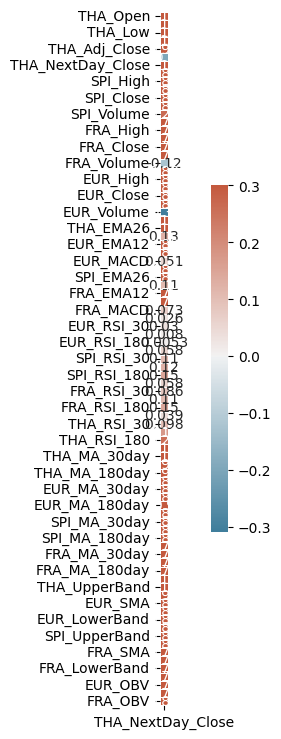

In [29]:
# Drop the 'FK_DT_Date' column and copy into Model_Corr df
Model_Corr = (Model_Norm.drop(columns=['FK_DT_Date'])).copy()

# Compute the correlation matrix
corr = Model_Corr.corr()

# Focus on 'THA_NextDay_Close' correlations
corr = corr[['THA_NextDay_Close']]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [38]:
# See correlation matrix
Model_corr_df = Model_Corr.corr()
Model_corr_df

,THA_Open,THA_High,THA_Low,THA_Close,THA_Adj_Close,THA_Volume,THA_NextDay_Close,SPI_Open,SPI_High,SPI_Low,...,SPI_SMA,SPI_UpperBand,SPI_LowerBand,FRA_SMA,FRA_UpperBand,FRA_LowerBand,THA_OBV,EUR_OBV,SPI_OBV,FRA_OBV
THA_Open,1.000000,0.999771,0.999739,0.999570,0.991711,-0.195471,0.999061,0.882150,0.881961,0.882218,...,0.882829,0.881349,0.882710,0.747530,0.743470,0.744933,0.788723,0.788723,0.792930,0.831546
THA_High,0.999771,1.000000,0.999641,0.999778,0.991781,-0.192194,0.999269,0.882680,0.882554,0.882715,...,0.883488,0.882246,0.883112,0.748875,0.745367,0.745670,0.787647,0.787647,0.792486,0.831904
THA_Low,0.999739,0.999641,1.000000,0.999783,0.992036,-0.198388,0.999242,0.882005,0.881785,0.882160,...,0.882498,0.880744,0.882671,0.746137,0.741448,0.744194,0.789931,0.789931,0.793709,0.831402
THA_Close,0.999570,0.999778,0.999783,1.000000,0.992084,-0.195547,0.999464,0.882349,0.882207,0.882486,...,0.882992,0.881480,0.882906,0.747577,0.743461,0.745027,0.788865,0.788865,0.793157,0.831625
THA_Adj_Close,0.991711,0.991781,0.992036,0.992084,1.000000,-0.195379,0.991684,0.914472,0.914415,0.914563,...,0.914923,0.913859,0.914309,0.724866,0.720857,0.722472,0.824873,0.824873,0.840049,0.837557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FRA_LowerBand,0.744933,0.745670,0.744194,0.745027,0.722472,-0.161812,0.744686,0.766498,0.766008,0.766655,...,0.767875,0.761372,0.773343,0.995114,0.981055,1.000000,0.562272,0.562272,0.519563,0.789141
THA_OBV,0.788723,0.787647,0.789931,0.788865,0.824873,-0.231994,0.788818,0.845107,0.844848,0.845333,...,0.844530,0.842546,0.845083,0.563510,0.560061,0.562272,1.000000,1.000000,0.957637,0.766140
EUR_OBV,0.788723,0.787647,0.789931,0.788865,0.824873,-0.231994,0.788818,0.845107,0.844848,0.845333,...,0.844530,0.842546,0.845083,0.563510,0.560061,0.562272,1.000000,1.000000,0.957637,0.766140
SPI_OBV,0.792930,0.792486,0.793709,0.793157,0.840049,-0.253468,0.793267,0.897412,0.897356,0.897470,...,0.897082,0.896241,0.896311,0.521752,0.519553,0.519563,0.957637,0.957637,1.000000,0.712745


In [ ]:
# Split Dataframe into Training, Validation, Testing


# Assuming Model_Norm is your DataFrame
df = Model_Norm

# First split: 80% for training, 20% for temporary
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42)

# Second split on the temporary set: 50% for validation, 50% for testing
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)


In [39]:
# Assuming df is your DataFrame and 'col1' and 'col2' are the columns you don't want to normalize
cols_to_normalize = [col for col in Model_Norm.columns if col not in ['FK_DT_Date', 'THA_NextDay_Close']]

scaler = MinMaxScaler()

Model_Norm[cols_to_normalize] = scaler.fit_transform(Model_Norm[cols_to_normalize])
